In [68]:
%matplotlib inline

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import netCDF4
import scipy.io
import gsw
from glob import glob
from collections import OrderedDict
import datetime as dt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from functions import *

In [47]:
# import scipy.io as spio

# def loadmat(filename):
#     '''
#     this function should be called instead of direct spio.loadmat
#     as it cures the problem of not properly recovering python dictionaries
#     from mat files. It calls the function check keys to cure all entries
#     which are still mat-objects
#     '''
#     data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
#     return _check_keys(data)

# def _check_keys(dict):
#     '''
#     checks if entries in dictionary are mat-objects. If yes
#     todict is called to change them to nested dictionaries
#     '''
#     for key in dict:
#         if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
#             dict[key] = _todict(dict[key])
#     return dict        

# def _todict(matobj):
#     '''
#     A recursive function which constructs from matobjects nested dictionaries
#     '''
#     dict = {}
#     for strg in matobj._fieldnames:
#         elem = matobj.__dict__[strg]
#         if isinstance(elem, spio.matlab.mio5_params.mat_struct):
#             dict[strg] = _todict(elem)
#         else:
#             dict[strg] = elem
#     return dict

import scipy.io as spio
def my_loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        elif isinstance(elem,np.ndarray):
            dict[strg] = _tolist(elem)
        else:
            dict[strg] = elem
    return dict

def _tolist(ndarray):
    '''
    A recursive function which constructs lists from cellarrays 
    (which are loaded as numpy ndarrays), recursing into the elements
    if they contain matobjects.
    '''
    elem_list = []            
    for sub_elem in ndarray:
        if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
            elem_list.append(_todict(sub_elem))
        elif isinstance(sub_elem,np.ndarray):
            elem_list.append(_tolist(sub_elem))
        else:
            elem_list.append(sub_elem)
    return elem_list

basedir = '.'
datadir = 'data'
infile = 'Glacier_mr'
suffix = '.mat'
# mat = scipy.io.loadmat(os.path.join(basedir, datadir + '/other', infile + suffix))
mat = my_loadmat(os.path.join(basedir, datadir + '/other', infile + suffix))
print mat.keys()

['int_mrB', '__globals__', 'int_mrN', '__header__', 'int_mrM', 'modelday', 'int_mrS', 'model_mattime', 'time', '__version__']


In [48]:
vars = ['int_mrB','int_mrM','int_mrN','int_mrS','model_mattime','modelday','time']
Variables = mat.keys()

In [50]:
def matlab2datetime(matlab_datenum):
    day = dt.datetime.fromordinal(int(matlab_datenum))
    dayfrac = dt.timedelta(days=matlab_datenum%1) - dt.timedelta(days = 366)
    return day + dayfrac

DATES = [matlab2datetime(tval) for tval in mat['model_mattime']]

In [174]:
values = np.array([mat[vars[0]], mat[vars[1]], mat[vars[2]], mat[vars[3]]])
df = []
df = pd.DataFrame(data=values.T, columns=vars[0:4], index=pd.DatetimeIndex(DATES))
df = df.apply(pd.to_numeric, errors='ignore')
# df.index = pd.to_datetime(df['DATES'])
df = df[3:]
df.head()

,int_mrB,int_mrM,int_mrN,int_mrS
2000-10-02,-7.210286,-0.999245,-1.962803,-0.757383
2000-10-07,-7.058087,-1.320457,-2.015037,-0.706376
2000-10-12,-6.531418,-1.318801,-1.848323,-0.721723
2000-10-17,-6.294812,-1.089311,-1.978726,-0.733409
2000-10-22,-6.387940,-0.960829,-1.947216,-0.711449


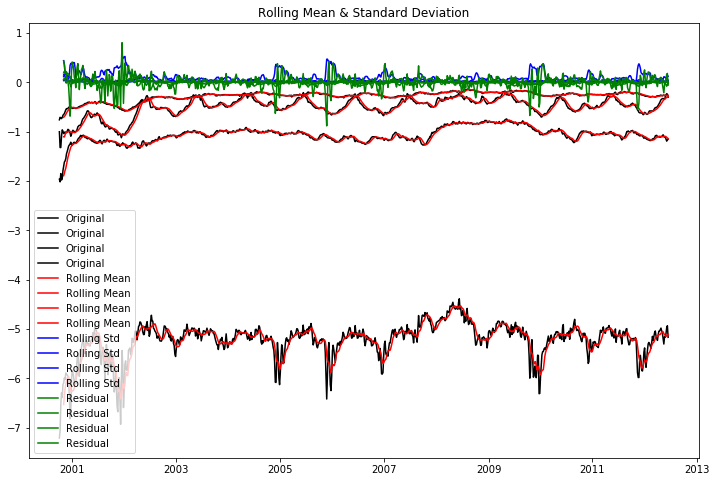

Results of Dickey-Fuller Test:


In [175]:
def test_stationarity(timeseries):
    # Determing rolling statistics
#     rolmean = pd.rolling_mean(timeseries, window=7)
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()
    rolres = timeseries - rolmean
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='black', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='blue', label='Rolling Std')
    res = plt.plot(rolres, color='green', label='Residual')

    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    # Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
#     for key, value in dftest[4].items():
#         dfoutput['Critical Value (%s)' % key] = value
#     print dfoutput
    
test_stationarity(df)

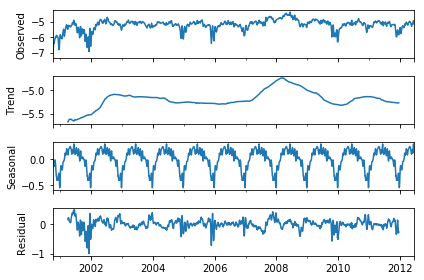

In [176]:
di = df.resample('1D').interpolate(method='linear')
decomposition = seasonal_decompose(di['int_mrB'], model='additive', freq=365)
fig = decomposition.plot()

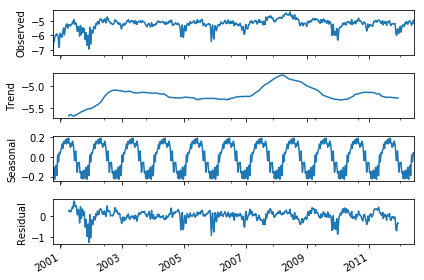

In [177]:
decomposition = seasonal_decompose(df['int_mrB'], model='additive', freq=76)
fig = decomposition.plot()

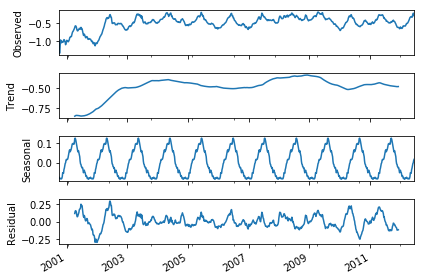

In [178]:
decomposition = seasonal_decompose(df['int_mrM'], model='additive', freq=76)
fig = decomposition.plot()

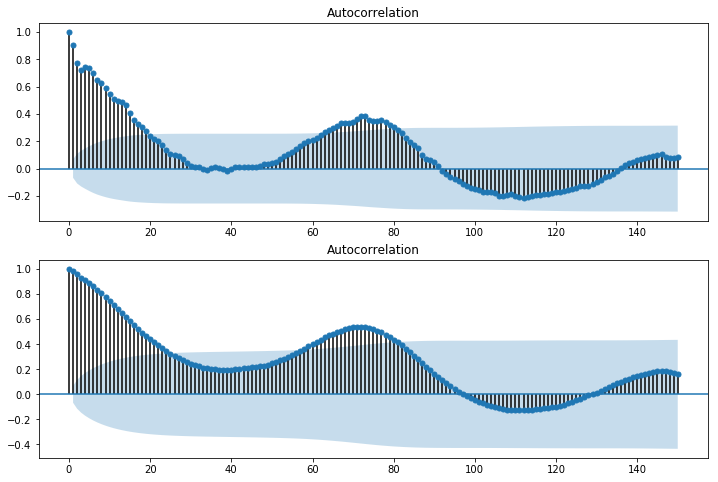

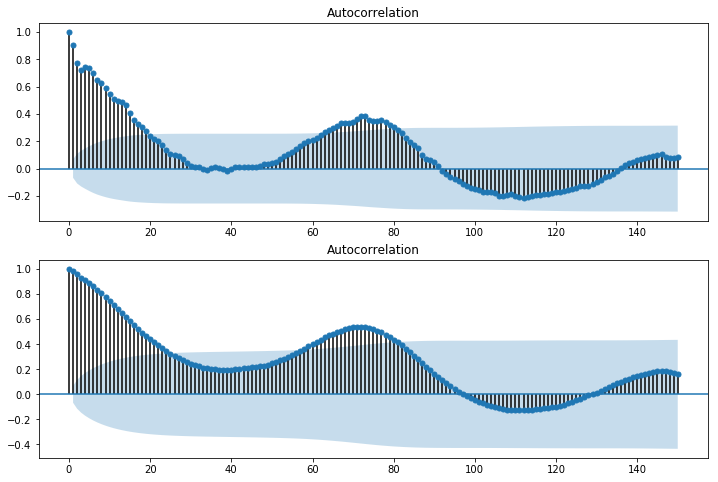

In [179]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(df['int_mrB'].squeeze(), lags=150, ax=ax1)
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_acf(df['int_mrM'].squeeze(), lags=150, ax=ax2)

In [151]:
df.corr()

,int_mrB,int_mrM,int_mrN,int_mrS
int_mrB,1.000000,0.649353,0.424114,0.631141
int_mrM,0.649353,1.000000,0.666069,0.827469
int_mrN,0.424114,0.666069,1.000000,0.733031
int_mrS,0.631141,0.827469,0.733031,1.000000


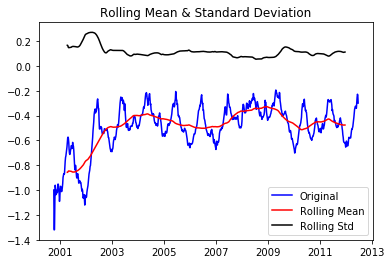

Results of Dickey-Fuller Test:
Test Statistic                  -4.665971
p-value                          0.000097
#Lags Used                       8.000000
Number of Observations Used    846.000000
Critical Value (5%)             -2.864962
Critical Value (1%)             -3.438103
Critical Value (10%)            -2.568592
dtype: float64


In [180]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, w):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=w,center=True).mean()
    rolstd = timeseries.rolling(window=w,center=True).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
#     resid = plt.plot(timeseries - rolmean, color='green', label = 'Resid')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    
test_stationarity(df['int_mrM'], 76)